In [1]:
import pandas as pd
import seaborn as sns # plotting library
import matplotlib.pyplot as plt

import numpy as np # library to work with numerical arrays (matrices)


In [2]:
def select_tracks_by_length( df, min_track_length, max_track_length ): 
    """
    Function that selects data subset based on track length
    """
    def test_length( x):
        if len(x)>=min_track_length and len(x) <= max_track_length:
            return True
        else:
            return False
        
    df_sub            = df[ df.groupby('cell_lbl')['t'].transform(test_length) ].copy()
    # copy() is needed here, because otherwise returned df_sub will be POINTING to the original "df" data.
    # so if we would like to add a column to df_sub (e.g. df_sub['new_column'] = 0) , we would get a warning,
    # because df_sub is not "real" on itself, it is just pointing to a part (subset) of the original data.
    # to make it stand-alone dataframe, we copy().
    
    print( 'Strains: ', df_sub['bact'].unique())
    print( 'Cell track length thresholds (including both ends!): [%d, %d]'%(min_track_length, max_track_length))
    print( 'Cells number (selected/all): %d / %d'%( len(df_sub['cell_lbl'].unique()), len(df['cell_lbl'].unique()) ) )
    print( 'Rows (selected/all): %d / %d'%(df_sub.shape[0] , df.shape[0]) )

    return  df_sub


In [3]:
#load cleaned data
file_path = '../data/dataset_clean_1.csv'
df        = pd.read_csv( file_path )

# select the tracks with maximum possible length
df_long = select_tracks_by_length(df, 18, 18)
df_long.tail(20)

Strains:  ['Lpp WT' 'Lpp dotA']
Cell track length thresholds (including both ends!): [18, 18]
Cells number (selected/all): 828 / 3989
Rows (selected/all): 14904 / 42598


,t,bact,mito_frag,mito_pot,annexin,hoechst,leg_n,leg_area,infected,cell_lbl
42554,16.0,Lpp dotA,0.426667,0.294981,131.529,1390.770,3.0,3.55417,1.0,w10_f25_c4
42555,17.0,Lpp dotA,0.452582,0.238033,131.159,1410.090,5.0,3.51051,1.0,w10_f25_c4
42556,0.0,Lpp dotA,0.322461,0.697968,123.432,246.038,3.0,8.98585,1.0,w10_f25_c5
42557,1.0,Lpp dotA,0.363566,0.503171,128.726,344.752,8.0,17.53510,1.0,w10_f25_c5
42558,2.0,Lpp dotA,0.372865,0.500391,131.357,407.579,13.0,20.14610,1.0,w10_f25_c5
42559,3.0,Lpp dotA,0.394393,0.404912,131.346,486.990,10.0,11.34360,1.0,w10_f25_c5
42560,4.0,Lpp dotA,0.400186,0.375544,132.921,482.484,12.0,18.47820,1.0,w10_f25_c5
42561,5.0,Lpp dotA,0.407315,0.337375,132.638,449.480,11.0,17.02860,1.0,w10_f25_c5
42562,6.0,Lpp dotA,0.392255,0.389693,137.550,556.541,11.0,22.27690,1.0,w10_f25_c5
42563,7.0,Lpp dotA,0.391286,0.427454,135.115,422.754,9.0,22.94050,1.0,w10_f25_c5


# Goal: 
- Select (automatically if possible) the cells, in which bacteria replicate (replicating bacteria = RB)
- We have two signals for that: legionella area and legionella number
- Keep in mind that number may not reflect actual number of bacteria. Perhaps area is a better metric.
- Be always careful where these metrics come from; the bacteria might have been segmented erroneously.


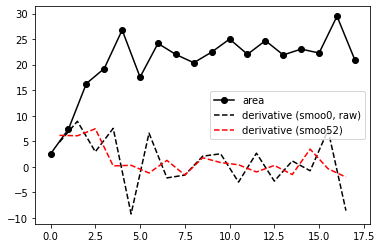

In [4]:
# In this cell I'm testing some functions that can calculate derivative of a signal in each time point.
# I do this because we could try selecting the RB cells by checking how their legionella area behaves in each time point.
# if derivative of area is positive => the area grows.
# if it is negative => the area decreases.

# We could use the derivative values like this:
# if dy/dx at ANY POINT > some threshold => there was enough bacteria growth => the cell is RB.
# I'll use this "get_derivative" function in the cell below.


def get_derivative( x, y, smoo_params=(5,2)):
    """This function calculates derivative between each 2 time points.
    Returns 
    xc array (centers of each 2 time points)
    dydx array (derivatives in each x point) 
    """
    from scipy.signal import savgol_filter

    """smoo_params = params for savizky-golai filter: (window, polynome order)"""
    if smoo_params != 0:
        y = savgol_filter( y, *smoo_params )    

    xc = x[0:-1] + np.diff( x )/2 # middle between x points
    dydx = np.diff( y ) / np.diff( x )
    # derivative at each x point       
    return  xc, dydx


def test_derivative(cur_df):
    
    # collect the cells, where infected==1 occurs at least once
    infected_ni = []
    for ind, gr in cur_df.groupby(['cell_lbl']):
        if gr['infected'].sum() > 0:
            infected_ni.append( gr )

    # let's just take group n=3 (random choice)
    i = 3
    t = infected_ni[i]['t']
    la = infected_ni[i]['leg_area']

    # plot original area
    fig,ax =plt.subplots(1)
    ax.plot(t, la, 'ko-', label='area')

    # calculate derivative using different settings for filtering the noise
    x0,y0 = get_derivative( t, la, 0 )
    x52,y52 = get_derivative( t, la, (5,2) )

    ax.plot( x0, y0, 'k--',label='derivative (smoo0, raw)')
    ax.plot( x52, y52, 'r--',label='derivative (smoo52)')
    plt.legend()
    
    
test_derivative(df_long)



In [5]:
def select_rb_cells_by_areaChange( df, dA_thr, points_N=2, verbose=True ):
    """
    Select RB cells by checking the total change of bacteria Area.
    dA_thr : float
        Threshold for area change
    points_to_avg : int
        dA is calculated as A1 - A0, where 
        A0 = mean(A[first N points])
        A1 = mean(A[last  N pointa])
        Number of points on the ends of a track to be averaged. This is to reduce noise and get more stable metrics
        of the data in the beginning 
    """
    # lists that hold cells ids:
    rb_cells_lbl = []      
    nonrb_cells_lbl = []
    
    # number of points to average
    Np = points_N

    # go over each cell:
    for lbl, gr in df.groupby(['cell_lbl']):
        # times = gr['t'].values
        areas = gr['leg_area'].values 
        # calculate Area change:
        # array[-N:] -> returns last N elements
        # array[0:N] -> returns first N elements
        dA = areas[-Np:].mean() - areas[0:Np].mean()
        if dA >= dA_thr:
            rb_cells_lbl.append( lbl )
        else:
            nonrb_cells_lbl.append( lbl )
                
    # find indices of those cells that are in the list of RB cells
    inds = df['cell_lbl'].isin( rb_cells_lbl )

    # add column RB:
    df['rb'] = 0 # 0 by default
    df.loc[inds, 'rb'] = 1  # set to 1 those that are from rb_cells_lbl list 
    
    if verbose:
        print('\nRB cells selection: ')
        print( 'RB cells/total cells: %d / %d'%(len(rb_cells_lbl), len(rb_cells_lbl)+len(nonrb_cells_lbl)) )    
    
    return  df, rb_cells_lbl, nonrb_cells_lbl 



# I'm not going to use selection of RT cells by derivatives anyway, but here is the function:
# def select_rb_cells_by_areaDerivatives( df, Np_to_avg, der_thr, verbose=True):
    
#     # TODO: Np_to_avg take first/last two points INDEPENDENTLY of their time (may easily be not 0,1 h)
    
#     selected_cell_lbl = []      
#     deselected_cell_lbl = []   

#     # go over each track:
#     for ind,gr in df.groupby(['cell_lbl']):
#         # EACH POINT DERIVATIVE
#         x,y = get_derivative(  gr['t'].values, gr['leg_area'].values, 0 )    
#         if (y > der_thr).sum() >0:
#             selected_cell_lbl.append( gr['cell_lbl'].unique()[0] )
#         else:
#             deselected_cell_lbl.append( gr['cell_lbl'].unique()[0] )   
#     
#     # data:
#     df['rb'] = 0
#     df.loc[ df['cell_lbl'].isin( selected_cell_lbl ), 'rb'] = 1   
    
#     if verbose:
#         print('\nRBT selection: ')
#         print( 'RBT tracks/total tracks: %d / %d'%(len(selected_cell_lbl), len(selected_cell_lbl)+len(deselected_cell_lbl)) )    
    
#     return  df, selected_cell_lbl, deselected_cell_lbl 

Strains:  ['Lpp WT' 'Lpp dotA']
Cell track length thresholds (including both ends!): [14, 18]
Cells number (selected/all): 1904 / 3989
Rows (selected/all): 32555 / 42598

RB cells selection: 
RB cells/total cells: 43 / 1904


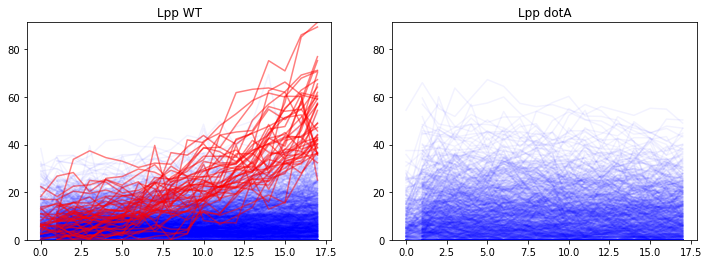

In [6]:
features    = ['mito_frag', 'mito_pot', 'annexin', 'hoechst', 'leg_n', 'leg_area' ] #df_selected.columns
strains     = [ 'Lpp WT' , 'Lpp dotA'] # df['bact'].unique()

# let's be a bit more tolerant and choose cells with tracks of length 14 to 18.
df_long = select_tracks_by_length(df, 14, 18)

# mark those that are RB cells.
# Note in the output message there are very few RB cells compared to all cells. Try to be even more tolerant in
# the track length filtering (above), but even then there will be very few RB cells.
df_long_rb, rb_lbls, nrb_lbls = select_rb_cells_by_areaChange( df_long, 28, points_N=2, verbose=True )

fig, axs = plt.subplots(1,2, figsize=(12,4))
area_max = df_long_rb['leg_area'].max()


for ax,strain in zip(axs, strains ):
    
    # select a subset of data for RB+ and RB-
    _df_rb = df_long_rb[(df_long_rb['bact']==strain) & 
                         (df_long_rb['rb']==1)]
    _df_nrb = df_long_rb[(df_long_rb['bact']==strain) & 
                         (df_long_rb['rb']==0)]                  

    for lbl, gr in _df_nrb.groupby('cell_lbl'):
        ax.plot( gr['t'], gr['leg_area'], 'b-', alpha=0.05)
  
    for lbl, gr in _df_rb.groupby('cell_lbl'):
        ax.plot( gr['t'], gr['leg_area'], 'r-', alpha=0.5 ) 
        
    ax.set_title(strain)
    ax.set_ylim([0,area_max])

# It is clear from these plots that Lpp WT produce way more RB cells than the mutant Lpp dotA.

# We have selected RB cells
- Now let's plot other features (metrics)
- Plot as individual tracks + the curve averaged over the populations
- Plot as violins

In [7]:
def set_alpha(ax, alpha):
    from matplotlib.collections import PolyCollection
    for art in ax.get_children():
        if isinstance(art, PolyCollection):
            art.set_alpha( alpha )

In [8]:
# Select data
cur_strains = ['Lpp WT', 'Lpp dotA' ] # = df['bact'].unique()
features    = ['mito_frag', 'mito_pot', 'annexin', 'hoechst', 'leg_n', 'leg_area'] # = df.columns

# rbt params
min_tr_length = 14
max_tr_length = 18

dA_thresh   = 28 #43 #20
Np          = 2 # number of points to average

df_long     = select_tracks_by_length(df, min_tr_length, max_tr_length)
df_long_rb, rb_lbls, nrb_lbls = select_rb_cells_by_areaChange( df_long, dA_thresh, Np )
 

Strains:  ['Lpp WT' 'Lpp dotA']
Cell track length thresholds (including both ends!): [14, 18]
Cells number (selected/all): 1904 / 3989
Rows (selected/all): 32555 / 42598

RB cells selection: 
RB cells/total cells: 43 / 1904


Text(0.5, 0, 'time')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


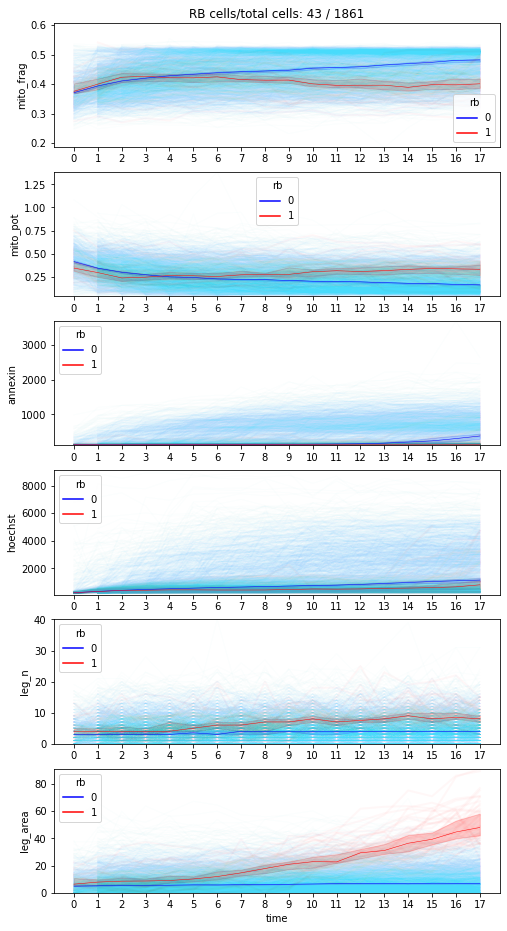

In [9]:
# INDIVIDUAL TRACKS + POPULATION AVERAGED CURVE
%matplotlib inline

fig_width       = 8.0
cols = ['blue', 'red']
    
fig, axs    = plt.subplots( len(features), 1, figsize=(fig_width, len(features)*fig_width/3) )

for ax,feat in zip(axs, features): 
    for lbl, gr in df_long_rb.groupby(['cell_lbl']):
        if gr['cell_lbl'].unique()[0] in rb_lbls:  
            # settings for RB cells plot
            col = np.array( (255, 107, 107) )/255 # color pink
            al = 0.05
            lw = 2
        else:
            # settings for nonRB cells plot
            col = np.array( (72, 219, 251) )/255 # color blue
            al = 0.02
            lw = 1
        ax.plot( gr['t'].values, gr[feat].values, '-', alpha=al, color = col, lw=lw )        
        
    # population average
    sns.lineplot( data=df_long_rb, x='t', y=feat,
                 hue='rb', palette=cols, 
                 ax=ax, linewidth=0.5, estimator=np.median )
            
    ax.set_ylim( [df[feat].min(), df[feat].max()] )
    #ax.set_ylim( violin_ylims[feat] )
    ax.set_ylabel( feat )
    ax.set_xlabel( '' )
    ax.set_xticks( range(0,18) )    

axs[0].set_title( 'RB cells/total cells: %d / %d'%(len(rb_lbls), len(nrb_lbls)) )
axs[-1].set_xlabel( 'time' )


Text(0.5, 0, 'time')

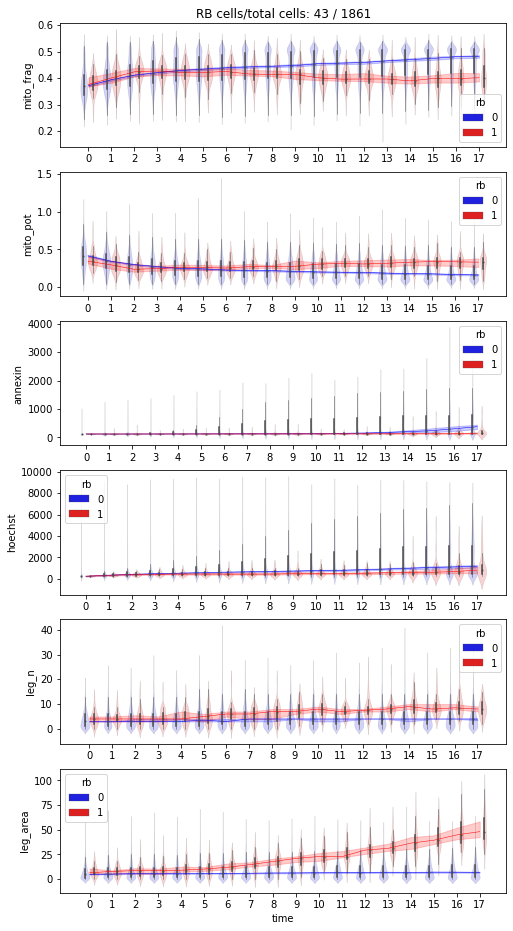

In [10]:
# VIOLINS + POPULATION AVERAGED CURVE
%matplotlib inline

fig_width       = 8.0
cols = ['blue', 'red']  

fig, axs    = plt.subplots( len(features), 1, figsize=(fig_width, len(features)*fig_width/3))

for ax,feat in zip(axs, features ): 
    sns.violinplot( data=df_long_rb, x='t', y=feat, 
                   hue='rb', palette=cols, linewidth=0.5, ax=ax)
    sns.lineplot( data=df_long_rb, x='t', y=feat, 
                 hue='rb', palette=cols, linewidth=0.5, 
                 ax=ax, estimator=np.median, legend=False)

    set_alpha( ax, 0.2)
    ax.set_xlabel('') # remove x label
    # for some reason sns makes x ticks labels with .0 (e.g. 0.0, 1.0, etc) - this looks ugly.
    # lets change them to integers without .0 part. This will do the trick:
    ax.set_xticklabels( ax.get_xticks() )
    # axs[i].set_ylim( violin_ylims[feat] )
axs[0].set_title( 'RB cells/total cells: %d / %d'%(len(rb_lbls), len(nrb_lbls)) )
axs[-1].set_xlabel('time')


    

### Discussion:
- RB cells have dynamics of Mitochondrial potential and fragmentation significantly different from those of non RB cells (starting from 3-4 frame)
- However, there initial values of any feature are the same. It means that we cannot use any of these features (or their linear combinations) to predict what causes the different behavior (all initial conditions are the same).
- But it might be something different than initial conditions; i.e. one could say that for whatever reason, in RB cells at frame 3-4 mitochondria start to fragment, and this is the reason why leg_area starts to increase at 3-4 frame.

In [11]:
df_long_rb

,t,bact,mito_frag,mito_pot,annexin,hoechst,leg_n,leg_area,infected,cell_lbl,rb
0,0.0,Lpp WT,0.431446,0.256032,126.836,217.240,8.0,10.00760,1.0,w1_f1_c1,0
1,1.0,Lpp WT,0.484533,0.121939,125.335,346.889,0.0,0.00000,0.0,w1_f1_c1,0
2,2.0,Lpp WT,0.488785,0.115264,125.288,432.361,0.0,0.00000,0.0,w1_f1_c1,0
3,3.0,Lpp WT,0.478215,0.140332,125.717,346.814,0.0,0.00000,0.0,w1_f1_c1,0
4,4.0,Lpp WT,0.474289,0.178344,125.518,426.399,1.0,2.29667,1.0,w1_f1_c1,0
...,...,...,...,...,...,...,...,...,...,...,...
42586,13.0,Lpp dotA,0.440898,0.227144,133.875,440.976,3.0,5.58013,1.0,w10_f25_c6,0
42587,14.0,Lpp dotA,0.435091,0.231253,139.243,450.542,4.0,6.33987,1.0,w10_f25_c6,0
42588,15.0,Lpp dotA,0.394414,0.329596,139.649,414.522,8.0,6.10409,1.0,w10_f25_c6,0
42589,16.0,Lpp dotA,0.428944,0.220211,144.880,427.168,4.0,9.02951,1.0,w10_f25_c6,0


In [12]:
df_long

,t,bact,mito_frag,mito_pot,annexin,hoechst,leg_n,leg_area,infected,cell_lbl,rb
0,0.0,Lpp WT,0.431446,0.256032,126.836,217.240,8.0,10.00760,1.0,w1_f1_c1,0
1,1.0,Lpp WT,0.484533,0.121939,125.335,346.889,0.0,0.00000,0.0,w1_f1_c1,0
2,2.0,Lpp WT,0.488785,0.115264,125.288,432.361,0.0,0.00000,0.0,w1_f1_c1,0
3,3.0,Lpp WT,0.478215,0.140332,125.717,346.814,0.0,0.00000,0.0,w1_f1_c1,0
4,4.0,Lpp WT,0.474289,0.178344,125.518,426.399,1.0,2.29667,1.0,w1_f1_c1,0
...,...,...,...,...,...,...,...,...,...,...,...
42586,13.0,Lpp dotA,0.440898,0.227144,133.875,440.976,3.0,5.58013,1.0,w10_f25_c6,0
42587,14.0,Lpp dotA,0.435091,0.231253,139.243,450.542,4.0,6.33987,1.0,w10_f25_c6,0
42588,15.0,Lpp dotA,0.394414,0.329596,139.649,414.522,8.0,6.10409,1.0,w10_f25_c6,0
42589,16.0,Lpp dotA,0.428944,0.220211,144.880,427.168,4.0,9.02951,1.0,w10_f25_c6,0


In [13]:
pd.concat([df_long,df_long_rb]).drop_duplicates(keep=False)

,t,bact,mito_frag,mito_pot,annexin,hoechst,leg_n,leg_area,infected,cell_lbl,rb
